In [1]:
import os
import random
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from datetime import date, timedelta

sys.path.append("../..")

from gemini.utils import *
from drift_detector.utils import *
from drift_detector.rolling_window import *
from drift_detector.detector import Detector
from drift_detector.reductor import Reductor
from drift_detector.tester import TSTester, DCTester
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

2022-10-10 11:11:26,878 INFO cyclops.orm     - Database setup, ready to run queries!


## Config parameters

In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
TIMESTEPS = 6
AGGREGATION_TYPE = "time"
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW", "PMH","SBK"]
ACADEMIC=["MSH","PMH", "SMH","UHNTW","UHNTG","PMH","SBK"]
COMMUNITY=["THPC","THPM"]
OUTCOME = "mortality"
THRESHOLD=0.05
NUM_TIMESTEPS = 6
STAT_WINDOW=30
LOOKUP_WINDOW=0
STRIDE=1

SHIFT = input("Select experiment: ")  # hospital_type
MODEL_PATH = os.path.join(PATH,"saved_models",SHIFT+"_lstm.pt")

if SHIFT == "hosp_type_academic":
    exp_params = {
        'source': ACADEMIC, 
        'target': COMMUNITY,
        'shift_type':"hospital_type"
    }

if SHIFT == "hosp_type_community":
    exp_params = {
        'source':COMMUNITY, 
        'target': ACADEMIC,
        'shift_type':"hospital_type"
    }

Select experiment:  hosp_type_academic


## Get data

In [3]:
admin_data, x, y = get_gemini_data(PATH)

2022-10-10 11:13:07,138 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-10-10 11:13:07,541 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-10-10 11:13:07,731 INFO cyclops.feature_handler - Loading features from file...
2022-10-10 11:13:07,737 INFO cyclops.feature_handler - Found file to load for static features...
2022-10-10 11:13:07,740 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-10-10 11:13:07,779 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-10-10 11:13:13,036 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-10-10 11:13:21,937 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


## Get prediction model

In [4]:
output_dim = 1
batch_size = 64
input_dim = 108
timesteps = 6
hidden_dim = 64
layer_dim = 2
dropout = 0.2
last_timestep_only = False

device = get_device()

model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model = get_temporal_model("lstm", model_params).to(device)
model, optimizer, n_epochs = load_ckp(MODEL_PATH, model)

## Rolling window

In [5]:
DR_TECHNIQUE="BBSDs_trained_LSTM"
MD_TEST="mmd"
SAMPLE=1000
CONTEXT_TYPE="lstm"
PROJ_TYPE="lstm"
START_DATE = date(2019, 1, 1)
END_DATE = date(2020, 8, 1)

## Hospital type experiment over time

In [6]:
## Set constant reference distribution
random.seed(1)
print("Query data %s ..." % SHIFT)

(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITALS)

# Normalize data
X_tr_normalized  = normalize(admin_data, X_tr, AGGREGATION_TYPE, TIMESTEPS)
X_val_normalized = normalize(admin_data, X_val, AGGREGATION_TYPE, TIMESTEPS)
X_t_normalized = normalize(admin_data, X_t, AGGREGATION_TYPE, TIMESTEPS)

# Get labels
y_tr = get_label(admin_data, X_tr, OUTCOME)
y_val = get_label(admin_data, X_val, OUTCOME)
y_t = get_label(admin_data, X_t, OUTCOME)

# Scale data
X_tr_scaled = scale(X_tr_normalized)
X_val_scaled = scale(X_val_normalized)
X_t_scaled = scale(X_t_normalized)

# Process data
X_tr_final = process(X_tr_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_val_final = process(X_val_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_t_final = process(X_t_scaled, AGGREGATION_TYPE, TIMESTEPS)

train_ids=list(X_tr_normalized.index.get_level_values(0).unique())
val_ids=list(X_val_normalized.index.get_level_values(0).unique())
exclude_ids=train_ids+val_ids
    
print("Get target data streams...")
data_streams = get_serving_data(
    x, 
    y, 
    admin_data, 
    START_DATE, 
    END_DATE, 
    stride=1, 
    window=1, 
    ids_to_exclude=exclude_ids, 
    encounter_id='encounter_id', 
    admit_timestamp='admit_timestamp'
)
    
print("Get Shift Reductor...")
reductor = Reductor(
    dr_method = DR_TECHNIQUE,
    model_path = MODEL_PATH,
    n_features = len(feats),
    var_ret = 0.8,
)
    
print("Get Shift Tester...")
tester = TSTester(
    tester_method=MD_TEST,
)
    
print("Get Shift Detector...")
detector = Detector(
    reductor = reductor,
    tester = tester,
    p_val_threshold = 0.05,
)
    
detector.fit(X_val_final)
    
print("Get Rolling Window...")

rolling_window = RollingWindow(
    shift_detector = detector,
    optimizer = optimizer
)
    
drift_metrics = rolling_window.drift(
    data_streams,
    SAMPLE,
    STAT_WINDOW,
    LOOKUP_WINDOW,
    STRIDE
)
        
performance_metrics = rolling_window.performance(
    data_streams,
    STAT_WINDOW,
    LOOKUP_WINDOW,
    STRIDE
)
    
results = {'timestamps':[(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=LOOKUP_WINDOW+STAT_WINDOW)).strftime("%Y-%m-%d") for date in data_streams['timestamps']][:-STAT_WINDOW]}
results.update(drift_metrics)
results.update(performance_metrics)
results.to_pickle(os.path.join(PATH,SHIFT+"_"+DR_TECHNIQUE+"_"+MD_TEST+"_results.pkl"))   

Query data hosp_type_academic ...
Get target data streams...
2019-01-01 - 2019-01-02
2020-01-01 - 2020-01-02
Get Shift Reductor...
Get Shift Tester...
Get Shift Detector...


2022-10-10 11:18:41.467034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 11:18:41.591264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/nfs/home/subasriv/.cache/pypoetry/virtualenvs/cyclops-KKtuQLwg-py3.9/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/opt/R/4.0.5/lib/R/lib:/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-10-10 11:18:41.591399: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu

Get Rolling Window...


  9%|▉         | 50/530 [08:17<1:22:12, 10.28s/it]

P-value below threshold.
Ref --> 48 - 78 	P-Value:  0.02


 10%|▉         | 51/530 [08:28<1:23:22, 10.44s/it]

P-value below threshold.
Ref --> 49 - 79 	P-Value:  0.02


 10%|▉         | 52/530 [08:38<1:23:29, 10.48s/it]

P-value below threshold.
Ref --> 50 - 80 	P-Value:  0.01


 10%|█         | 53/530 [08:49<1:23:18, 10.48s/it]

P-value below threshold.
Ref --> 51 - 81 	P-Value:  0.03


 10%|█         | 54/530 [08:59<1:23:01, 10.47s/it]

P-value below threshold.
Ref --> 52 - 82 	P-Value:  0.03


 10%|█         | 55/530 [09:10<1:22:41, 10.45s/it]

P-value below threshold.
Ref --> 53 - 83 	P-Value:  0.03


 14%|█▍        | 74/530 [12:22<1:15:55,  9.99s/it]

P-value below threshold.
Ref --> 72 - 102 	P-Value:  0.02


 14%|█▍        | 76/530 [12:41<1:14:58,  9.91s/it]

P-value below threshold.
Ref --> 74 - 104 	P-Value:  0.03


 15%|█▍        | 78/530 [13:01<1:13:57,  9.82s/it]

P-value below threshold.
Ref --> 76 - 106 	P-Value:  0.02


 15%|█▌        | 80/530 [13:21<1:13:51,  9.85s/it]

P-value below threshold.
Ref --> 78 - 108 	P-Value:  0.04


 15%|█▌        | 81/530 [13:31<1:13:48,  9.86s/it]

P-value below threshold.
Ref --> 79 - 109 	P-Value:  0.04


 16%|█▌        | 86/530 [14:20<1:13:14,  9.90s/it]

P-value below threshold.
Ref --> 84 - 114 	P-Value:  0.02


 16%|█▋        | 87/530 [14:30<1:13:19,  9.93s/it]

P-value below threshold.
Ref --> 85 - 115 	P-Value:  0.0


 17%|█▋        | 88/530 [14:40<1:12:46,  9.88s/it]

P-value below threshold.
Ref --> 86 - 116 	P-Value:  0.0


 17%|█▋        | 89/530 [14:49<1:12:06,  9.81s/it]

P-value below threshold.
Ref --> 87 - 117 	P-Value:  0.0


 17%|█▋        | 90/530 [14:59<1:11:27,  9.74s/it]

P-value below threshold.
Ref --> 88 - 118 	P-Value:  0.01


 17%|█▋        | 91/530 [15:09<1:11:18,  9.75s/it]

P-value below threshold.
Ref --> 89 - 119 	P-Value:  0.02


 18%|█▊        | 95/530 [15:48<1:10:43,  9.75s/it]

P-value below threshold.
Ref --> 93 - 123 	P-Value:  0.04


 19%|█▊        | 99/530 [16:28<1:11:35,  9.97s/it]

P-value below threshold.
Ref --> 97 - 127 	P-Value:  0.04


 31%|███▏      | 166/530 [27:49<1:01:49, 10.19s/it]

P-value below threshold.
Ref --> 164 - 194 	P-Value:  0.02


 32%|███▏      | 168/530 [28:09<1:01:09, 10.14s/it]

P-value below threshold.
Ref --> 166 - 196 	P-Value:  0.02


 32%|███▏      | 169/530 [28:19<1:00:54, 10.12s/it]

P-value below threshold.
Ref --> 167 - 197 	P-Value:  0.04


 32%|███▏      | 171/530 [28:40<1:00:55, 10.18s/it]

P-value below threshold.
Ref --> 169 - 199 	P-Value:  0.01


 32%|███▏      | 172/530 [28:50<1:00:40, 10.17s/it]

P-value below threshold.
Ref --> 170 - 200 	P-Value:  0.01


 33%|███▎      | 173/530 [29:00<1:00:20, 10.14s/it]

P-value below threshold.
Ref --> 171 - 201 	P-Value:  0.0


 33%|███▎      | 174/530 [29:10<1:00:14, 10.15s/it]

P-value below threshold.
Ref --> 172 - 202 	P-Value:  0.02


 33%|███▎      | 175/530 [29:21<1:00:23, 10.21s/it]

P-value below threshold.
Ref --> 173 - 203 	P-Value:  0.01


 33%|███▎      | 176/530 [29:31<1:00:57, 10.33s/it]

P-value below threshold.
Ref --> 174 - 204 	P-Value:  0.02


 34%|███▎      | 178/530 [29:52<1:00:12, 10.26s/it]

P-value below threshold.
Ref --> 176 - 206 	P-Value:  0.01


 34%|███▍      | 179/530 [30:02<1:00:10, 10.29s/it]

P-value below threshold.
Ref --> 177 - 207 	P-Value:  0.01


 67%|██████▋   | 357/530 [1:00:59<30:39, 10.64s/it]

P-value below threshold.
Ref --> 355 - 385 	P-Value:  0.04


 81%|████████  | 428/530 [1:28:51<30:59, 18.23s/it]  

P-value below threshold.
Ref --> 426 - 456 	P-Value:  0.02


 81%|████████  | 429/530 [1:29:09<30:40, 18.22s/it]

P-value below threshold.
Ref --> 427 - 457 	P-Value:  0.01


 81%|████████  | 430/530 [1:29:27<30:26, 18.27s/it]

P-value below threshold.
Ref --> 428 - 458 	P-Value:  0.0


 81%|████████▏ | 431/530 [1:29:45<29:57, 18.15s/it]

P-value below threshold.
Ref --> 429 - 459 	P-Value:  0.0


 82%|████████▏ | 432/530 [1:30:03<29:23, 17.99s/it]

P-value below threshold.
Ref --> 430 - 460 	P-Value:  0.01


 82%|████████▏ | 433/530 [1:30:21<29:14, 18.08s/it]

P-value below threshold.
Ref --> 431 - 461 	P-Value:  0.01


 82%|████████▏ | 434/530 [1:30:40<29:06, 18.19s/it]

P-value below threshold.
Ref --> 432 - 462 	P-Value:  0.03


 94%|█████████▍| 529/560 [06:00<00:21,  1.47it/s]


AttributeError: 'dict' object has no attribute 'to_pickle'

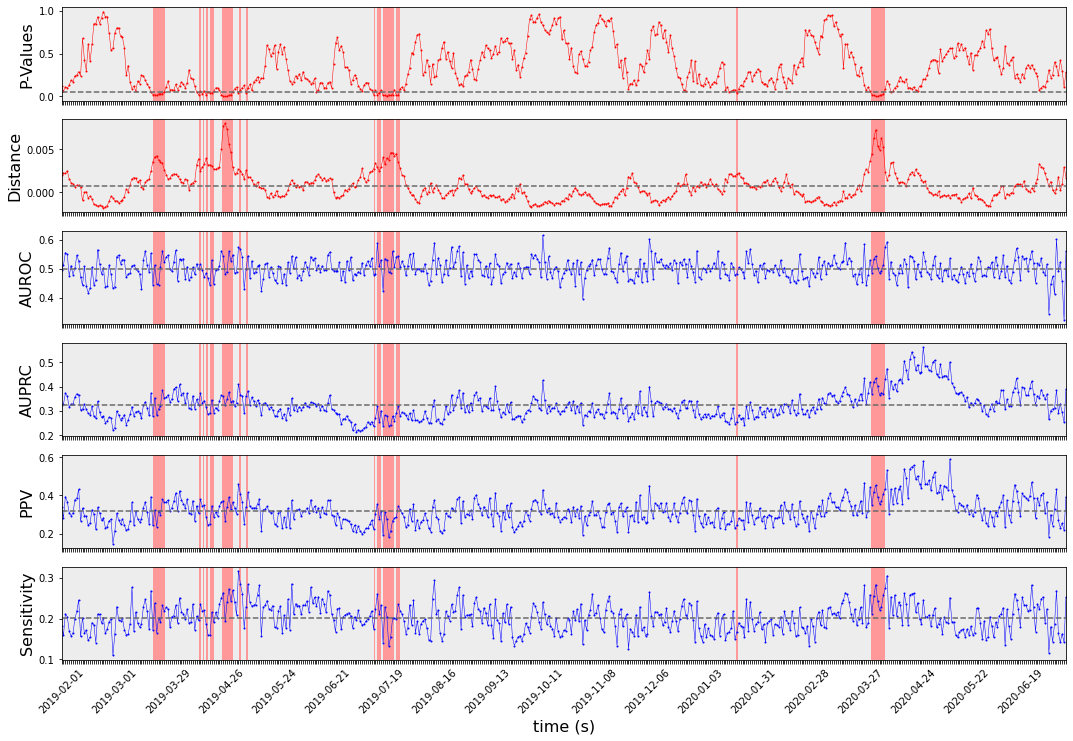

In [8]:
threshold=0.05
sig_drift = np.array(results['shift_detected'])[np.newaxis]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(18,12))
cmap = ListedColormap(['lightgrey','red'])
ax1.plot(results['timestamps'], results['p_val'], '.-', color="red", linewidth=0.5, markersize=2)
ax1.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax1.axhline(y=threshold, color='dimgrey', linestyle='--')
ax1.set_ylabel('P-Values',fontsize=16)
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)
  
ax2.plot(results['timestamps'], results['distance'], '.-',color="red", linewidth=0.5, markersize=2)
ax2.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax2.set_ylabel('Distance',fontsize=16)
ax2.axhline(y=np.mean(results['distance']), color='dimgrey', linestyle='--')
ax2.set_xticklabels([])
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax3.plot(results['timestamps'], results['auroc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax3.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax3.set_ylabel('AUROC', fontsize=16)
ax3.axhline(y=np.mean(results['auroc']), color='dimgrey', linestyle='--')
ax3.set_xticklabels([])
ax3.pcolorfast(ax3.get_xlim(), ax3.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax4.plot(results['timestamps'], results['auprc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax4.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax4.set_ylabel('AUPRC',fontsize=16)
ax4.axhline(y=np.mean(results['auprc']), color='dimgrey', linestyle='--')
ax4.set_xticklabels([])
ax4.pcolorfast(ax4.get_xlim(), ax4.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax5.plot(results['timestamps'], results['prec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax5.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax5.set_ylabel('PPV', fontsize=16)
ax5.axhline(y=np.mean(results['prec1']), color='dimgrey', linestyle='--')
ax5.set_xticklabels([])
ax5.pcolorfast(ax5.get_xlim(), ax5.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax6.plot(results['timestamps'], results['rec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax6.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax6.set_ylabel('Sensitivity',fontsize=16)
ax6.set_xlabel('time (s)', fontsize=16)
ax6.axhline(y=np.mean(results['rec1']), color='dimgrey', linestyle='--')
ax6.tick_params(axis='x', labelrotation=45)
ax6.pcolorfast(ax6.get_xlim(), ax6.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

for index, label in enumerate(ax6.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()